In [439]:
%cd ~\ZZSC9020_Project\Group10_project
import os
import shutil
import numpy as np
import pandas as pd
import pmdarima as pmd

from datetime import datetime as dt
from datetime import timedelta

import matplotlib.pyplot as plt
import seaborn as sns


C:\Users\KJR\ZZSC9020_Project\Group10_project


c:\Users\KJR\anaconda3\envs\zzsc9020_project\Lib\site-packages\IPython\core\magics\osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
c:\Users\KJR\anaconda3\envs\zzsc9020_project\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## ARIMA modelling

Forecasting requires looking at underlying processes to learn from historical data in such a way that we can create a function such that

$$
f(x_1,x_2,x_3,...,x_{n-1}) = x_n.
$$

One of these processes is known as an *ARIMA* process. The ARIMA process involves the following prerequisites in its definition

In [449]:
PATH = os.getcwd().replace("\\", "/")
PATH += "/data/SILO/"

QLD_DATA= pd.read_csv(PATH+"daily_merged_nsw.csv",header=0)
QLD_WILDFIRE = pd.read_csv(PATH+"nsw_wildfire.csv",header=0)
#QLD_WILDFIRE = QLD_WILDFIRE[(QLD_WILDFIRE['area_ha'] > 10) & (QLD_WILDFIRE['pct_burn'] > 0)]
QLD_WILDFIRE = QLD_WILDFIRE[(QLD_WILDFIRE['area_ha'] > 10)]
QLD_DATA['DATETIME'] = pd.to_datetime(QLD_DATA['DATETIME'])
QLD_WILDFIRE['StartDate'] = pd.to_datetime(QLD_WILDFIRE['StartDate'], dayfirst=True, format='mixed')
QLD_WILDFIRE['EndDate'] = pd.to_datetime(QLD_WILDFIRE['EndDate'], dayfirst=True, format='mixed')
QLD_WILDFIRE.drop(['label', 'type', 'burnstatus', 'owning_age', 'pct_burn'],axis=1,inplace=True)
QLD_WILDFIRE = QLD_WILDFIRE.loc[QLD_WILDFIRE['StartDate'].dt.year > 2009]
QLD_WILDFIRE.reset_index(inplace=True)
QLD_WILDFIRE.drop('index',axis=1,inplace=True)
QLD_WILDFIRE['EventId'] = QLD_WILDFIRE.index+1

QLD_WILDFIRE['EventPeriod']=QLD_WILDFIRE[['StartDate', 'EndDate']].apply(
    lambda row: pd.date_range(row['StartDate'], row['EndDate']), 
    axis=1
)

QLD_WILDFIRE['EventPair'] = QLD_WILDFIRE[['EventId','EventPeriod','area_ha']].values.tolist()

total_series = pd.Series([])
for i in range(2915):
    quick_series = pd.Series(data = QLD_WILDFIRE['EventPair'][i][0], index=QLD_WILDFIRE['EventPair'][i][1])
    total_series = pd.concat([total_series,quick_series])
bushfire_dates = total_series.index.unique()

bushfire_dates = bushfire_dates.to_series(name="DATETIME").reset_index()
bushfire_dates.drop(['index'],axis=1,inplace=True)
bushfire_dates['bushfire'] = 1

WILDFIRE_SERIES = pd.date_range(start="2010-01-01",end="2021-03-18").to_frame(name="DATETIME")

merged_dates = pd.merge(WILDFIRE_SERIES, bushfire_dates, how='outer', on='DATETIME')
merged_dates = merged_dates.fillna(0)
QLD_DATA['bushfire'] = merged_dates['bushfire']

QLD_DATA['DATETIME'] = pd.to_datetime(QLD_DATA['DATETIME'])
QLD_DATA

ValueError: time data "25/01/2001" doesn't match format "%m/%d/%Y", at position 1. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [493]:
pd.to_datetime(QLD_WILDFIRE['StartDate'], dayfirst=True, format='mixed')

0      2001-04-08
1      2001-01-25
2      2001-01-25
3      2001-04-10
9      2000-09-05
          ...    
9491   2019-12-28
9492   2020-01-01
9493   2019-11-26
9494   2019-11-26
9495   2019-12-12
Name: StartDate, Length: 4645, dtype: datetime64[ns]

In [451]:
#QLDF_StartDate = pd.to_datetime(pd.Series(data=['2012-03-15','2013-01-21','2014-04-11','2014-12-08','2015-01-21','2015-02-19','2015-03-11','2017-03-28','2017-10-16','2018-03-24','2019-03-19','2020-02-08','2021-01-02'],name='StartDate'))
#QLDF_EndDate = pd.to_datetime(pd.Series(data=['2012-03-15','2013-01-29','2014-04-14','2014-12-14','2015-01-29','2015-02-22','2015-03-21','2017-04-06','2017-10-19','2018-03-29','2019-03-27','2020-02-14','2021-01-12'],name='EndDate'))


In [452]:
#For NSW
QLDF_StartDate = pd.to_datetime(pd.Series(data=['2011-03-20','2012-03-05', '2013-01-21', '2016-09-09', '2017-03-28','2018-11-28', '2021-02-24', '2021-03-16'],name='StartDate'))
QLDF_EndDate = pd.to_datetime(pd.Series(data=['2011-03-21','2012-03-25', '2013-01-29', '2016-09-19', '2017-04-06', '2018-11-28', '2021-02-25', '2021-03-18'],name='EndDate'))

In [453]:
QLD_FLOOD = pd.DataFrame(data=[QLDF_StartDate, QLDF_EndDate]).transpose()
QLD_FLOOD['EventId'] = 1
QLD_FLOOD['EventPeriod']=QLD_FLOOD[['StartDate', 'EndDate']].apply(
    lambda row: pd.date_range(row['StartDate'], row['EndDate']), 
    axis=1
)
QLD_FLOOD['EventPair'] = QLD_FLOOD[['EventId','EventPeriod']].values.tolist()

total_series = pd.Series([])
for i in range(8):
    quick_series = pd.Series(data = QLD_FLOOD['EventPair'][i][0], index=QLD_FLOOD['EventPair'][i][1])
    total_series = pd.concat([total_series,quick_series])
flood_dates = total_series.index.unique()

flood_dates = flood_dates.to_series(name="DATETIME").reset_index()
flood_dates.drop(['index'],axis=1,inplace=True)
flood_dates['FLOOD'] = 1

FLOOD_SERIES = pd.date_range(start="2010-01-01",end="2021-03-18").to_frame(name="DATETIME")

merged_dates = pd.merge(FLOOD_SERIES, flood_dates, how='outer', on='DATETIME')
merged_dates = merged_dates.fillna(0)
QLD_DATA['flood'] = merged_dates['FLOOD']

QLD_DATA['DATETIME'] = pd.to_datetime(QLD_DATA['DATETIME'])
QLD_DATA

C:\Users\KJR\AppData\Local\Temp\ipykernel_22936\3392282369.py:12: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  total_series = pd.concat([total_series,quick_series])


,DATETIME,TOTALDEMAND,TEMPERATURE,Rain,Evap,Radn,VP,RH,flood
0,2010-01-01,7801.35,25.09,0.2,5.2,14.6,23.1,76.35,0.0
1,2010-01-02,8017.46,24.77,0.0,5.9,18.4,22.0,67.80,0.0
2,2010-01-03,7399.90,19.43,15.2,1.9,7.3,19.1,83.25,0.0
3,2010-01-04,8241.72,20.63,0.2,3.4,14.4,18.2,75.15,0.0
4,2010-01-05,8827.81,22.66,0.0,6.8,28.1,16.9,65.35,0.0
...,...,...,...,...,...,...,...,...,...
4090,2021-03-14,7092.58,18.04,15.8,3.7,3.1,19.9,89.45,0.0
4091,2021-03-15,6930.62,17.12,9.4,3.7,19.2,11.6,61.25,0.0
4092,2021-03-16,7330.38,18.26,0.0,2.3,9.1,14.3,73.75,1.0
4093,2021-03-17,7428.19,19.41,7.0,4.1,11.3,17.3,76.60,1.0


In [454]:
QLD_DATA['DATETIME'] = pd.to_datetime(QLD_DATA['DATETIME'])

In [455]:
QLD_DATA.index = QLD_DATA['DATETIME']
QLD_DATA.drop('DATETIME',axis=1,inplace=True)
QLD_DATA

,TOTALDEMAND,TEMPERATURE,Rain,Evap,Radn,VP,RH,flood
DATETIME,,,,,,,,
2010-01-01,7801.35,25.09,0.2,5.2,14.6,23.1,76.35,0.0
2010-01-02,8017.46,24.77,0.0,5.9,18.4,22.0,67.80,0.0
2010-01-03,7399.90,19.43,15.2,1.9,7.3,19.1,83.25,0.0
2010-01-04,8241.72,20.63,0.2,3.4,14.4,18.2,75.15,0.0
2010-01-05,8827.81,22.66,0.0,6.8,28.1,16.9,65.35,0.0
...,...,...,...,...,...,...,...,...
2021-03-14,7092.58,18.04,15.8,3.7,3.1,19.9,89.45,0.0
2021-03-15,6930.62,17.12,9.4,3.7,19.2,11.6,61.25,0.0
2021-03-16,7330.38,18.26,0.0,2.3,9.1,14.3,73.75,1.0


In [456]:
flood_dates = QLD_DATA[QLD_DATA['flood']==1]

In [457]:
summer_qld = QLD_DATA.query("index.dt.month in [12,1,2,3]")

In [458]:
print(flood_dates['Rain'].mean())
print(flood_dates['RH'].mean())
print(flood_dates['TOTALDEMAND'].mean())
print(flood_dates['TEMPERATURE'].mean())

7.694915254237288
73.66186440677967
7914.584576271187
19.312542372881357


In [459]:
print(QLD_DATA['Rain'].mean())
print(QLD_DATA['RH'].mean())
print(QLD_DATA['TOTALDEMAND'].mean())
print(QLD_DATA['TEMPERATURE'].mean())

2.3156532356532358
68.08197802197803
8112.902302808303
17.412536656891493


In [468]:
print(summer_qld['Rain'].mean())
print(summer_qld['RH'].mean())
print(summer_qld['TOTALDEMAND'].mean())
print(summer_qld['TEMPERATURE'].mean())

2.992841956059532
68.05595322466336
8107.4306307583265
21.95469879518072


In [469]:
r = 7
leadup_days = []
for date in QLDF_StartDate:
    drange = pd.date_range(date-timedelta(days=r),date)
    for item in drange:
        leadup_days.append(item)

In [470]:
leadup_days = list(set(leadup_days))
leadup_days.sort()
#leadup_days = leadup_days[4:]
leadup_days

[Timestamp('2011-03-13 00:00:00'),
 Timestamp('2011-03-14 00:00:00'),
 Timestamp('2011-03-15 00:00:00'),
 Timestamp('2011-03-16 00:00:00'),
 Timestamp('2011-03-17 00:00:00'),
 Timestamp('2011-03-18 00:00:00'),
 Timestamp('2011-03-19 00:00:00'),
 Timestamp('2011-03-20 00:00:00'),
 Timestamp('2012-02-27 00:00:00'),
 Timestamp('2012-02-28 00:00:00'),
 Timestamp('2012-02-29 00:00:00'),
 Timestamp('2012-03-01 00:00:00'),
 Timestamp('2012-03-02 00:00:00'),
 Timestamp('2012-03-03 00:00:00'),
 Timestamp('2012-03-04 00:00:00'),
 Timestamp('2012-03-05 00:00:00'),
 Timestamp('2013-01-14 00:00:00'),
 Timestamp('2013-01-15 00:00:00'),
 Timestamp('2013-01-16 00:00:00'),
 Timestamp('2013-01-17 00:00:00'),
 Timestamp('2013-01-18 00:00:00'),
 Timestamp('2013-01-19 00:00:00'),
 Timestamp('2013-01-20 00:00:00'),
 Timestamp('2013-01-21 00:00:00'),
 Timestamp('2016-09-02 00:00:00'),
 Timestamp('2016-09-03 00:00:00'),
 Timestamp('2016-09-04 00:00:00'),
 Timestamp('2016-09-05 00:00:00'),
 Timestamp('2016-09-

In [471]:
leadup_data = QLD_DATA[QLD_DATA.index.floor('D').isin(leadup_days)]

In [472]:
print(leadup_data['Rain'].mean())
print(leadup_data['RH'].mean())
print(leadup_data['TOTALDEMAND'].mean())
print(leadup_data['TEMPERATURE'].mean())

3.95
70.9109375
7977.468593750001
20.5909375


KeyError: 0

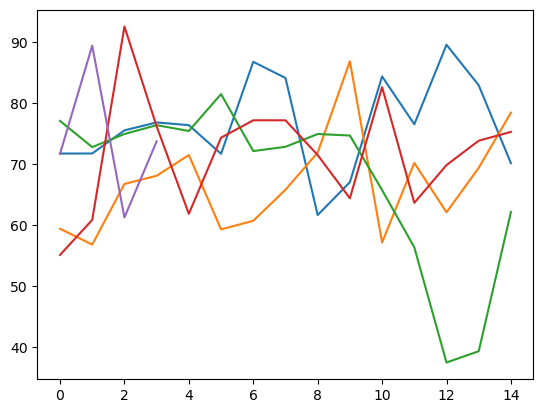

In [475]:
i = 0
c = 0
VALUE = 'RH'
start = []
end =[]
while c < 8:
    temp_plot = leadup_data[i:i+r+8].reset_index()
    start.append(temp_plot[VALUE][0])
    temp_plot = temp_plot[VALUE]
    temp_plot.plot()
    c += 1
    i += r+8

import statistics
print(statistics.mean(start))
print(statistics.mean(end))

In [476]:
QLD_DATA['temp_change'] = QLD_DATA['TEMPERATURE'] - QLD_DATA['TEMPERATURE'].shift(fill_value=25.02)
QLD_DATA['high_temp_change'] = np.where(abs(QLD_DATA['temp_change']) > 5, 1, 0)


In [477]:
QLD_DATA['humid_change'] = QLD_DATA['RH'] - QLD_DATA['RH'].shift(fill_value=69.75)
QLD_DATA['high_humid_change'] = np.where(abs(QLD_DATA['humid_change']) > 10, 1, 0)


In [478]:
QLD_DATA['rain_change'] = QLD_DATA['Rain'] - QLD_DATA['Rain'].shift(fill_value=0)
QLD_DATA['high_rain_change'] = np.where(abs(QLD_DATA['rain_change']) > 9, 1, 0)


In [479]:
hum_index = QLD_DATA[QLD_DATA['high_humid_change'] == 1].index
final_index = []
for i in hum_index:
    small = list(pd.date_range(i,i+timedelta(days=6)))
    final_index.extend(small)

final_index = list(set(final_index))
final_index.sort()

QLD_DATA['high_humid_past_week'] = QLD_DATA.index.floor('D').isin(final_index)


In [480]:
rain_index = QLD_DATA[QLD_DATA['high_rain_change'] == 1].index
final_index = []
for i in rain_index:
    small = list(pd.date_range(i,i+timedelta(days=6)))
    final_index.extend(small)

final_index = list(set(final_index))
final_index.sort()

QLD_DATA['high_rain_past_week'] = QLD_DATA.index.floor('D').isin(final_index)


In [481]:
rain_index = QLD_DATA[QLD_DATA['high_temp_change'] == 1].index
final_index = []
for i in rain_index:
    small = list(pd.date_range(i,i+timedelta(days=6)))
    final_index.extend(small)

final_index = list(set(final_index))
final_index.sort()

QLD_DATA['high_temp_past_week'] = QLD_DATA.index.floor('D').isin(final_index)


In [482]:
QLD_DATA['high_rain_past_week'] = QLD_DATA['high_rain_past_week'].shift(fill_value=False).astype('int')
QLD_DATA['high_humid_past_week'] = QLD_DATA['high_humid_past_week'].shift(fill_value=False).astype('int')
QLD_DATA['high_temp_past_week'] = QLD_DATA['high_temp_past_week'].shift(fill_value=False).astype('int')

In [484]:
QLD_DATA.to_csv(PATH+"NSW_Rolling_Data.csv",header=0)
QLD_DATA

,TOTALDEMAND,TEMPERATURE,Rain,Evap,Radn,VP,RH,flood,temp_change,high_temp_change,humid_change,high_humid_change,rain_change,high_rain_change,high_humid_past_week,high_rain_past_week,high_temp_past_week
DATETIME,,,,,,,,,,,,,,,,,
2010-01-01,7801.35,25.09,0.2,5.2,14.6,23.1,76.35,0.0,0.07,0,6.60,0,0.2,0,0,0,0
2010-01-02,8017.46,24.77,0.0,5.9,18.4,22.0,67.80,0.0,-0.32,0,-8.55,0,-0.2,0,0,0,0
2010-01-03,7399.90,19.43,15.2,1.9,7.3,19.1,83.25,0.0,-5.34,1,15.45,1,15.2,1,0,0,0
2010-01-04,8241.72,20.63,0.2,3.4,14.4,18.2,75.15,0.0,1.20,0,-8.10,0,-15.0,1,1,1,1
2010-01-05,8827.81,22.66,0.0,6.8,28.1,16.9,65.35,0.0,2.03,0,-9.80,0,-0.2,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-14,7092.58,18.04,15.8,3.7,3.1,19.9,89.45,0.0,-5.61,1,17.75,1,13.8,1,0,0,0
2021-03-15,6930.62,17.12,9.4,3.7,19.2,11.6,61.25,0.0,-0.92,0,-28.20,1,-6.4,0,1,1,1
2021-03-16,7330.38,18.26,0.0,2.3,9.1,14.3,73.75,1.0,1.14,0,12.50,1,-9.4,1,1,1,1
